<a href="https://colab.research.google.com/github/Yanh12/MA_automatische_Zusammenfassung/blob/master/abstraktive_Phase/Model1/lstm%2Battention(ngram_short_sum).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/MA_colab')
default_path = '/content/drive/My Drive/MA_colab/attn_lstm/ngram_short_sum/'

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('attention.py','wb').write(src)


Saving attention.py to attention.py


5138

# New Section

In [ ]:
from attention import AttentionLayer

In [ ]:
import pickle, re
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras import backend as K
from matplotlib import pyplot

Using TensorFlow backend.


In [ ]:
with open ('/content/drive/My Drive/MA_colab/abs_infos.p', 'rb') as filehandle:
  abs_selected = pickle.load(filehandle)
abs_selected = [x.lower().strip() for x in abs_selected]
with open('/content/drive/My Drive/MA_colab/cores_ngram.p', 'rb') as filehandle:
  #list of list, each inner list contains several sentences
  textRank = pickle.load(filehandle)
textRank = [' '.join(x) for x in textRank]

In [ ]:
#define what should be in tokenizer and what not and preprocessing articles according to that
to_exclude = '!"#$%&()*+/:;<=>@[\\]^_`{|}~\t\n'
to_tokenize = '.,:;!?-'
textRank_modified = []
for article in textRank:
  article = re.sub(r'(['+to_tokenize+'])', r' \1 ', article)
  article = re.sub(r'  +', ' ', article)
  textRank_modified.append(article)
abs_modified = []
for summary in abs_selected:
  summary = re.sub(r'(['+to_tokenize+'])', r' \1 ', summary)
  summary = re.sub(r'  +', ' ', summary)
  abs_modified.append(summary)


#add START and END tag for each selected abstract
abs_tagged = ['_START_ ' + x + ' _END_' for x in abs_modified]

max_len_text = 500
max_len_summary = 50

#train, validation split
x_tr_texts, x_val_texts, y_tr_texts, y_val_texts = train_test_split(textRank_modified[:15000],abs_tagged[:15000], test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#text Tokenizer by keras >> convert text sequences into integer representation
x_tokenizer = Tokenizer(filters=to_exclude)#,oov_token='UNK')
x_tokenizer.fit_on_texts((list(x_tr_texts) + list(x_val_texts)))
x_tr = x_tokenizer.texts_to_sequences(x_tr_texts)
x_val = x_tokenizer.texts_to_sequences(x_val_texts)
#padding zero to max length
x_tr = pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')
#defing the vocabulary size
x_voc_size = len(x_tokenizer.word_index) + 1
#get word-index dict
x_word_index = x_tokenizer.word_index
#summary Tokenizer
y_tokenizer = Tokenizer(filters=to_exclude)#,oov_token='UNK')
y_tokenizer.fit_on_texts((list(y_tr_texts) + list(y_val_texts)))
y_tr = y_tokenizer.texts_to_sequences(y_tr_texts)
y_val = y_tokenizer.texts_to_sequences(y_val_texts)
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')
y_voc_size = len(y_tokenizer.word_index) + 1
y_word_index = y_tokenizer.word_index

In [ ]:
print(y_tokenizer.word_index['the'])

2


In [ ]:
#building model
K.clear_session()


In [ ]:
#use pre-trained word embedding as Embedding.layer of the model
#load pretrained word embedding
"""
corpus-specific word embedding can provide some more precise information, but 
it also has the disadvantage that many rare word get ignored.
So, here where use a combined way to better represent the words:
   1. if the word is in the corpus-specific word-embedding file, use it.
   2. if the work is not in this file but in the pretrained embeddings from the
   commonly crawled documents, then use this.
   3. if a word neither in the specific file nor in the common file, initialize
   it with random numbers
"""
cl_embeddings_index = {}
with open('/content/drive/My Drive/MA_colab/CL_word2vec_300dim.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        cl_embeddings_index[word] = coefs


embeddings_index = {}
with open('/content/drive/My Drive/MA_colab/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs


#embedding_layer for Encoder, embedding_dim=300
embedding_dim = 300
embedding_matrix_encoder = np.zeros((x_voc_size,embedding_dim))
"""
if the word is in the word embedding dict, embedding_vector gets the corresponding value
if not, initilize the vector with random numbers
"""
for word, i in x_word_index.items():
  if word in cl_embeddings_index.keys():
     embedding_vector = cl_embeddings_index.get(word)
     embedding_matrix_encoder[i] = embedding_vector
  elif word in embeddings_index.keys():
     embedding_vector = embeddings_index.get(word)
     embedding_matrix_encoder[i] = embedding_vector
  else:
     embedding_vector=np.random.uniform(-1.0,1.0,(300,))
     embedding_matrix_encoder[i] = embedding_vector


"""
embedding_layer = Embedding ()
initilize the embedding layer:
params: input_dim = the vocabulary size
        output_dim = embedding dimension
        embeddings_initilizer: to initilize the embeddings
        input_length = the max length of the source text
        trainable = False, because we want the pre-trained model and not update it
"""
embedding_layer_encoder = Embedding(input_dim = x_voc_size, 
                                    output_dim = embedding_dim,
                                    embeddings_initializer=Constant(embedding_matrix_encoder), 
                                    input_length = max_len_text, 
                                    trainable = False)

#embedding_layer for Decoder
embedding_matrix_decoder = np.zeros((y_voc_size,embedding_dim))
for word, i in y_word_index.items():
   if word in cl_embeddings_index.keys():
     embedding_vector_y = cl_embeddings_index.get(word)
     embedding_matrix_decoder[i] = embedding_vector_y
   elif word in embeddings_index.keys():
     embedding_vector_y = embeddings_index.get(word)
     embedding_matrix_decoder[i] = embedding_vector_y
   else:
     embedding_vector_y = np.random.uniform(-1.0,1.0,(300,))
     embedding_matrix_decoder[i] = embedding_vector_y

embedding_layer_decoder = Embedding(input_dim = y_voc_size, 
                                    output_dim = embedding_dim,
                                    embeddings_initializer=Constant(embedding_matrix_decoder),
                                    input_length = max_len_summary, 
                                    trainable = False)

In [ ]:
#print(embedding_matrix_encoder[10])

In [ ]:
#builing the encoder (3 stacked lstms)
encoder_inputs = Input(shape=(max_len_text,))
encoder_embedding = embedding_layer_encoder(encoder_inputs)
#lstm1
encoder_lstm1 = LSTM(embedding_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)
#lstm2
encoder_lstm2 = LSTM(embedding_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#lstm 3
encoder_lstm3=LSTM(embedding_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#building the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = embedding_layer_decoder(decoder_inputs)
#the inital state of the decoder is the output of the encoder
decoder_lstm = LSTM(embedding_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding,initial_state=[state_h, state_c])

In [ ]:
#adding the attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#concatenating the attention output ans decoder lstm output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [ ]:
#building the dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [ ]:
#defing the whole model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:

#compling the model
model.compile(optimizer='adagrad', loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#callbacks=[es] (in the history)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
                  ,epochs=10,batch_size=64, validation_data=([x_val,y_val[:,:-1]]
                  , y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
model.save('/content/drive/My Drive/MA_colab/attn_lstm/ngram_short_sum/lstm_attn_ngram_short_sum.h5')

Train on 13500 samples, validate on 1500 samples
Epoch 1/10
  192/13500 [..............................] - ETA: 2:27 - loss: 9.3856 - acc: 0.1078

KeyboardInterrupt: ignored

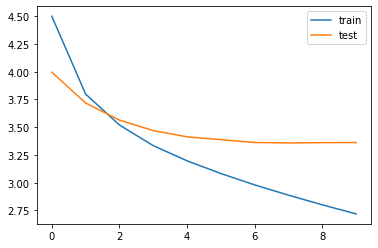

In [ ]:
#visualizeing the model training process
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title("Loss of Model1 with ngram_short_sum")
pyplot.legend()
pyplot.show()

### **Inferencing Phase**
--sampling with validation data

In [ ]:
#transform from integer back to words
reverse_y_word_index= {index: word for word, index in y_word_index.items()}
reverse_x_word_index= {index: word for word, index in x_word_index.items()}


In [ ]:
#inference for encoder and decoder
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(embedding_dim,))
decoder_state_input_c = Input(shape=(embedding_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,embedding_dim))

# Get the embeddings of the decoder sequence
decoder_embedding2= embedding_layer_decoder(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = y_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token

        try:
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_y_word_index[sampled_token_index]
        except KeyError:
            break
        
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=y_word_index['start']) and i!=y_word_index['end']):
        newString=newString+reverse_y_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_x_word_index[i]+' '
    return newString


#Prediction

In [ ]:
#load the trained model for prediction
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/MA_colab/attn_lstm/ngram_short_sum/lstm_attn_ngram_short_sum.h5',
                   custom_objects={'AttentionLayer': AttentionLayer})

In [ ]:
#define the test data
x_test_texts = textRank_modified[15000:]
y_test_texts = textRank_modified[15000:]
x_test = x_tokenizer.texts_to_sequences(x_test_texts)
x_test = pad_sequences(x_test,  maxlen=max_len_text, padding='post')
y_test = y_tokenizer.texts_to_sequences(y_test_texts)
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     16904400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 300), ( 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
#get the number and the correspoing layer
for i in range(len(model.layers)):
    print(i, model.layers[i].output_shape)

In [ ]:
#retrieval trained parameters for predicting

#get the encoder inputs
encoder_inputs = model.input[0] #encoder inputs, i.e. model input 1
#retrieve encoder outputs (outputs, last hidden state, last cell state of the third lstm layer)
encoder_outputs, state_h, state_c = model.layers[6].output #output of encoder lstm 3 
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
#get the decoder inputs, which is the second model inputs 
decoder_inputs = model.input[1]
#define the decoder embedding
decoder_embedding2= embedding_layer_decoder(decoder_inputs)
#the last lstm layer of the model ist the decoder lstm layer
decoder_lstm = model.layers[7]
#define the dec_h, dec_c, dec_hidded input shapes
decoder_state_input_h = Input(shape=(embedding_dim,),name="input_3")
decoder_state_input_c = Input(shape=(embedding_dim,),name="input_4")
decoder_hidden_state_input = Input(shape=(max_len_text,embedding_dim),name="input_5")
#obtain decoder outputs
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding2, 
                                                    initial_state=[decoder_state_input_h, 
                                                    decoder_state_input_c])
#the attention layer is the 9th layer of the model
attn_layer = model.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

#concatanation layer
concat_layer = model.layers[9]
decoder_inf_concat = concat_layer([decoder_outputs2, attn_out_inf])

#the last dense layer
decoder_dense = model.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
for i in range(len(x_test)):
    #print("Original summary:",seq2summary(y_test[i]))
    ref = open("/content/drive/My Drive/MA_colab/attn_lstm/ngram_short_sum/ref/ref_{}.txt".format(i), 'w')
    ref.write(seq2summary(y_val[i]))
    ref.close()
    #print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_len_text)))
    summ = open("/content/drive/My Drive/MA_colab/attn_lstm/ngram_short_sum/predicted/sum_{}.txt".format(i), 'w')
    summ.write(decode_sequence(x_val[i].reshape(1,max_len_text)))
    summ.close()
    print("\n")